# Gaussian process with vector inputs

In this notebook we look into Gaussian process regression for function of the form $f : \mathbb{R}^n \rightarrow \mathbb{R}$. 

We will assume an offline scenario where the training dataset $\mathcal{D} = (\mathbf{x}_i, y_i)_{i=1,...,N}$ is already available with $\mathbf{x}_i \in \mathbb{R}^3, y_i \in \mathbb{R}$.

In [26]:
import torch
# Define the training data
train_x = torch.randn(100, 3)  # 100 data points, each with 3-dimensional input
train_y = torch.sin(train_x[:, 0])  # Target function (sine of first dimension)

In [27]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(torch.zeros(1, 3), torch.zeros(1), likelihood)

In [28]:
from gpytorch import ExactMarginalLogLikelihood

# Initialize likelihood and model
model.train()
likelihood.train()

model.set_train_data(train_x, train_y, strict=False)

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = ExactMarginalLogLikelihood(likelihood, model)

training_iter=50

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.019   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.972   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.924   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 0.876   lengthscale: 0.854   noise: 0.554
Iter 5/50 - Loss: 0.828   lengthscale: 0.913   noise: 0.513
Iter 6/50 - Loss: 0.781   lengthscale: 0.973   noise: 0.474
Iter 7/50 - Loss: 0.733   lengthscale: 1.036   noise: 0.437
Iter 8/50 - Loss: 0.686   lengthscale: 1.100   noise: 0.402
Iter 9/50 - Loss: 0.639   lengthscale: 1.166   noise: 0.369
Iter 10/50 - Loss: 0.593   lengthscale: 1.233   noise: 0.339
Iter 11/50 - Loss: 0.547   lengthscale: 1.301   noise: 0.311
Iter 12/50 - Loss: 0.503   lengthscale: 1.370   noise: 0.284
Iter 13/50 - Loss: 0.458   lengthscale: 1.438   noise: 0.260
Iter 14/50 - Loss: 0.415   lengthscale: 1.507   noise: 0.237
Iter 15/50 - Loss: 0.372   lengthscale: 1.574   noise: 0.216
Iter 16/50 - Loss: 0.330   lengthscale: 1.641   noise: 0.196
Iter 17/50 - Loss: 0.289   length

In [29]:
# Set the model and likelihood into eval mode
model.eval()
likelihood.eval()

# Make predictions
test_x = torch.randn(10, 3)  # 10 test points
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

print("Predicted means:", observed_pred.mean)
print("Predicted variances:", observed_pred.variance)

Predicted means: tensor([-0.0868, -0.2970, -0.3341,  0.5722, -0.9330, -0.7268, -0.1691,  0.4523,
         0.7533,  0.2017])
Predicted variances: tensor([0.0071, 0.0062, 0.0088, 0.0064, 0.0114, 0.0063, 0.0067, 0.0063, 0.0131,
        0.0069])


## Further output testing

In theory for Q-learning predictions to work we need to fix the state part of the input and very the extra dimension for the action since the input domain is $\mathcal{S} \times \mathcal{A}$.

In [38]:
# Generate a single randomly generated 2D input
test_x_single = torch.randn(1, 2)  # Single test point, 2-dimensional input

test_xs = test_x_single.repeat(20, 1)

# Create variations of test_x by adding different values in the 3rd dimension
test_x_variations = torch.cat((test_xs, torch.randn(20, 1)), dim=1)  # Adding different values in the 3rd dimension

print(test_x_variations)

# Make predictions for the variations
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_variations = likelihood(model(test_x_variations))

print("Predicted means for variations:", observed_pred_variations.mean)
print("Predicted variances for variations:", observed_pred_variations.variance)

tensor([[ 1.5130,  1.2505,  0.2937],
        [ 1.5130,  1.2505, -0.2803],
        [ 1.5130,  1.2505,  0.5489],
        [ 1.5130,  1.2505,  0.1892],
        [ 1.5130,  1.2505,  0.1743],
        [ 1.5130,  1.2505,  0.4206],
        [ 1.5130,  1.2505, -0.9011],
        [ 1.5130,  1.2505, -0.9341],
        [ 1.5130,  1.2505, -0.5706],
        [ 1.5130,  1.2505, -1.8176],
        [ 1.5130,  1.2505, -0.5913],
        [ 1.5130,  1.2505,  0.3588],
        [ 1.5130,  1.2505,  0.3179],
        [ 1.5130,  1.2505, -0.1730],
        [ 1.5130,  1.2505, -1.6654],
        [ 1.5130,  1.2505, -0.7145],
        [ 1.5130,  1.2505, -1.2913],
        [ 1.5130,  1.2505,  0.0450],
        [ 1.5130,  1.2505, -0.5646],
        [ 1.5130,  1.2505,  0.4923]])
Predicted means for variations: tensor([0.9882, 1.0199, 0.9751, 0.9938, 0.9946, 0.9816, 1.0515, 1.0529, 1.0357,
        1.0616, 1.0368, 0.9848, 0.9869, 1.0139, 1.0649, 1.0430, 1.0637, 1.0017,
        1.0354, 0.9779])
Predicted variances for variations: tensor

tensor([ 0.2937, -0.2803,  0.5489,  0.1892,  0.1743,  0.4206, -0.9011, -0.9341,
        -0.5706, -1.8176, -0.5913,  0.3588,  0.3179, -0.1730, -1.6654, -0.7145,
        -1.2913,  0.0450, -0.5646,  0.4923])


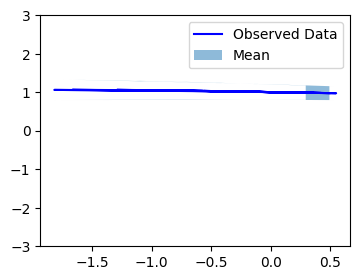

In [39]:
print(test_x_variations[:, -1])

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred_variations.confidence_region()
    # Plot training data as black stars
    # ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x_variations[:, -1].numpy(), observed_pred_variations.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x_variations[:, -1].numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

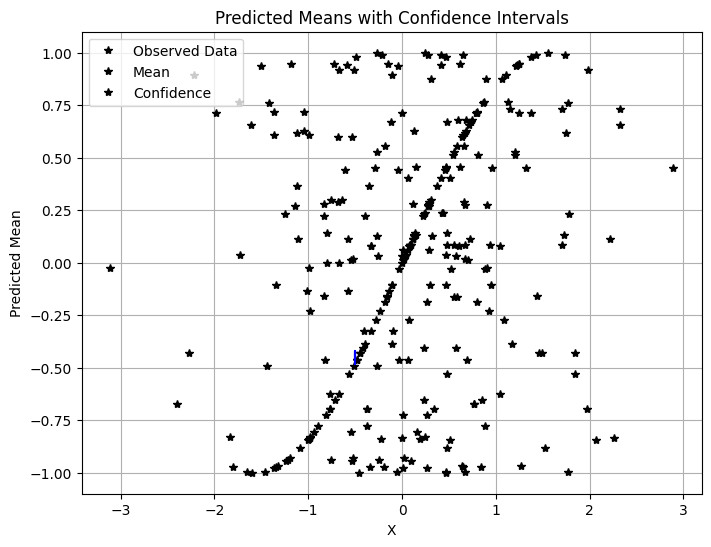

In [31]:
import matplotlib.pyplot as plt



with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred_variations.confidence_region()
    
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    
    # Plot predictive means as blue line
    ax.plot(test_x_variations[:, 0], observed_pred_variations.mean.numpy(), 'b')
    
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x_variations[:, 0], lower.numpy(), upper.numpy(), alpha=0.5)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Predicted Mean')
    ax.set_title('Predicted Means with Confidence Intervals')
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.grid(True)

plt.show()